In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import gamma as gamma_function

In [0]:
# constant parameters
X_min = 0
X_max = 100
alpha_min = 0.9
alpha_max = 1.0
pa_min = 0.05
pa_max = 0.25
N_nest = 25
N_itertotal = 100

gamma = 0.1          # noise factor
lamda = 1.5          # constant used in le'vy flight

In [0]:
# scalable parameters
total_nodes = 100
anchor_percent = 0.1
M = int(anchor_percent*total_nodes) # no. of anchor nodes
N = total_nodes - M # no. of unknown nodes

t_range = 25 # transmission range

In [0]:
# X_anchor = [[33,500],[1000,1000]]

In [0]:
# # distance calculator
# def dist(x1,y1,x2,y2):
#   dist_real = np.power(np.power(x1-x2,2) + np.power(y1-y2,2),0.5)
#   dist_err = dist_real + np.random.normal(0, gamma*dist_real)
#   return dist_real, dist_err

In [0]:
# neighbour anchors calculator
def neighbours(x, y):
  l = []
  for j in range(len(X_anchor)): # for every anchor nodes
    dist_real = np.power((np.power((x - X_anchor[j][0]), 2) + np.power((y - X_anchor[j][1]), 2)), 0.5)
    dist_err = dist_real + np.random.normal(0, (gamma*dist_real))

    if dist_err < t_range:
      l.append(X_anchor[j])
  
  # return len(l),l # returns no. of neighbouring anchors and  their coords as a tuple
  return l # neighbouring anchors coordinates

In [0]:
# l = neighbours(2,3)
# print(l)
# print(len(l))

In [0]:
# step size (alpha)
def alpha(n_iter):
  return alpha_max - ((n_iter/ N_itertotal) * (alpha_max - alpha_min)) # returns step size value

# Le'vy flight function
def levy():
  temp = np.power(((gamma_function(1 + lamda) * np.sin(np.pi * (lamda /2))) / (gamma_function((1 + lamda)/2) * lamda * np.power(2, ((lamda - 1)/2)) )), 1/lamda)
  u = np.random.normal(0, temp)
  v = np.random.normal(0,1)
  r = u / (np.power(abs(v), (1/lamda)))

  return r  # random walk value


In [0]:
# location limit tester
def limiter(x,y):
  if x > X_max and y > X_max:
    x,y = X_max, X_max
    # X_j = X_rand
  elif x > X_max and X_min < y < X_max:
    x,y = X_max, y
    # X_j = X_rand
  elif x > X_max and y < X_min:
    x,y = X_max, X_min
    # X_j = X_rand
  elif X_min < x < X_max and y < X_min:
    x,y = x, X_min
    # X_j = X_rand
  elif x < X_min and y < X_min:
    x,y = X_min, X_min
    # X_j = X_rand
  elif x < X_min and X_min < y < X_max:
    x,y = X_min, y
    # X_j = X_rand
  elif x < X_min and y > X_max:
    x,y = X_min, X_max
    # X_j = X_rand
  elif X_min < x < X_max and y > X_max:
    x,y = x, X_max
    # X_j = X_rand
  
  return x,y

In [0]:
# print(limiter(0,0))
# print(limiter(100,0))
# print(limiter(0,100))
# print(limiter(100,100))
# print(limiter(22,55))
# print(limiter(150,150))
# print(limiter(150,25))
# print(limiter(151,-40))
# print(limiter(34,-60))
# print(limiter(-32,-45))
# print(limiter(-70,22))
# print(limiter(-70,120))
# print(limiter(24,155))

# v = limiter(24,155)
# v = np.array(v)
# print(v[0])

In [0]:
# objective function (to minimize)
def objective(x,y):
  l = neighbours(x,y)
  if len(l) >= 3:
    m = len(l)
    rerror = []
    for ancn in l:
      dist_real = np.power((np.power((x - ancn[0]), 2) + np.power((y - ancn[1]), 2)), 0.5)
      dist_err = dist_real + np.random.normal(0, (gamma*dist_real))
      rerror.append(np.power(dist_real - dist_err,2))
    
    return np.sum(rerror)/m or None # mean of square of ranging error


In [0]:
# X_anchor = [[29,68],[16,79],[45,57]]
# neighbours(38,81)
# v = objective(38,81)
# print(v)

In [0]:
# # average localization error (ALE)
# def ale():
#   ans =

In [0]:
# localization success ratio (LSR)
def lsr(x,y):
  ans = (x/y) * 100

  return ans

In [0]:
# modified CS algorithm (paper)
def mod_cs():
  X_nest = []

  for i in range(N_nest):
    x_nest = np.random.randint(100)
    y_nest = np.random.randint(100)

    X_nest.append([x_nest, y_nest])

  Obj_X_nest = []
  for i in range(len(X_nest)):
    Obj_X_nest.append(objective(X_nest[i][0],X_nest[i][1]))
    # print(Obj_X_nest)

  N_iter = 1
  while (N_iter < N_itertotal):
    X_js = []
    for i in range(len(X_nest)):
      X_j = X_nest[i]
      X_j[0] = X_nest[i][0] + alpha(N_iter) * levy()
      X_j[1] = X_nest[i][1] + alpha(N_iter) * levy()

      v = limiter(X_j[0],X_j[1])
      X_j[0] = v[0]
      X_j[1] = v[1]

      F_j = objective(X_j[0],X_j[1]) or 0
      rand_k = np.random.randint(0, len(X_nest))
      F_k = objective(X_nest[rand_k][0], X_nest[rand_k][1]) or 0

      if F_j > F_k:
        X_j[0] = X_nest[rand_k][0]
        X_j[1] = X_nest[rand_k][1]
        F_j = F_k

      X_js.append(X_j)
      # X_js = np.array(X_js)
      # print(X_js)
      # break

    # Fitness values of current iteration's solutions
    Obj_X_js = []
    for i in range(len(X_js)):
      Obj_X_js.append(objective(X_js[i][0], X_js[i][1]))
    
    # Best solution selection
    Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
    F_min = Obj_X_js[np.argmin(Obj_X_js)]
    best_sol = X_js[np.argmin(Obj_X_js)]

    # Mutation probability
    Pa_j = []
    for i in Obj_X_js:
      K = i - F_min
      if K < 1:
        Pa_j.append(pa_min + (pa_max - pa_min) * K)
      else:
        Pa_j.append(pa_max / N_iter)

    # New random solutions generation according to mutation probability
    for i in range(len(Pa_j)):
      rand_temp = np.random.uniform(0, 1)
      if rand_temp < Pa_j[i]:
        my_x = np.random.randint(100)
        my_y = np.random.randint(100)
        X_js[i] = [my_x, my_y]

        v = limiter(X_js[i][0],X_js[i][1])
        X_js[i][0] = v[0]
        X_js[i][1] = v[1]

        Obj_X_js[i] = objective(X_js[i][0],X_js[i][1])
    # end for

    # Rank all solutions (and find current best)
    Obj_X_js = np.array([np.inf if i is None else i for i in Obj_X_js])
    F_min = Obj_X_js[np.argmin(Obj_X_js)]
    best_sol = X_js[np.argmin(Obj_X_js)]


    X_js = np.array(X_js)
    X_nest = X_js
    # print([X_js, Obj_X_js, best_sol, X_])
    # print(best_sol)
    
    N_iter += 1
  return best_sol


### MAIN

In [0]:
# anchor nodes random placement
X_anchor = []

for i in range(M):
  x_anchor = np.random.randint(100)
  y_anchor = np.random.randint(100)

  X_anchor.append([x_anchor, y_anchor])

In [118]:
X_anchor

[[89, 15],
 [45, 48],
 [4, 92],
 [49, 92],
 [48, 63],
 [87, 32],
 [76, 37],
 [62, 65],
 [58, 74],
 [23, 12]]

In [0]:
# unknown nodes random placement
X_unknown = []

for i in range(N):
  x_unknown = np.random.randint(100)
  y_unknown = np.random.randint(100)

  X_unknown.append([x_unknown, y_unknown])

In [0]:
X_unknown = np.array(X_unknown)
X_anchor = np.array(X_anchor)

In [121]:
X_anchor

array([[89, 15],
       [45, 48],
       [ 4, 92],
       [49, 92],
       [48, 63],
       [87, 32],
       [76, 37],
       [62, 65],
       [58, 74],
       [23, 12]])

In [0]:
# back up of original anchors and unknowns
X_anchor_og = X_anchor.copy()
X_unknown_og = X_unknown.copy()

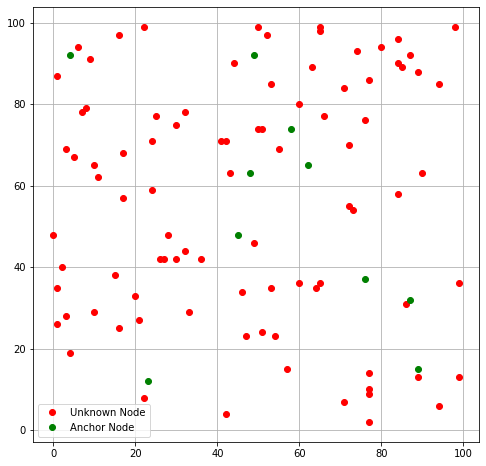

In [123]:
plt.figure(figsize=(8, 8))
plt.plot(X_unknown[:, 0], X_unknown[:, 1], 'ro', label="Unknown Node")
plt.plot(X_anchor[:, 0], X_anchor[:, 1], 'go', label="Anchor Node")
plt.legend()
plt.grid()
plt.show()

In [124]:
X_obj = []
for i in range(len(X_unknown)):
  X_obj.append(objective(X_unknown[i][0],X_unknown[i][1]))
print(X_obj)

[None, None, 0.9894793874039154, None, 3.9072073145435313, None, None, None, None, 0.9915715687631487, None, 3.643538740693995, None, None, 1.6426528770931712, None, None, None, None, 8.937548580349898, None, None, None, None, None, None, None, None, None, None, None, None, None, 2.6677016041211337, 6.669736675644118, 2.6682898632051217, 1.7072034109541774, None, None, None, None, None, None, None, 4.761692870641565, None, None, None, None, None, None, None, None, None, 1.7889507845473558, None, None, None, 1.3971375283635894, None, None, 1.2492694334725227, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 2.446349899276528, 1.9957157670071297, 4.391402665506692, 0.9781199633650596, None, None, None, None, None, 1.4363526011503793, None, None, None]


In [125]:
not_possible = 0
for i in range(len(X_obj)):
  if X_obj[i] == None:
    not_possible += 1

print(not_possible)

71


In [0]:
for i in range(len(X_unknown)):
  loc = neighbours(X_unknown[i][0],X_unknown[i][1])
  if len(loc) >= 3:
    X_anchor = loc
    f_start = objective(X_unknown[i][0],X_unknown[i][1])

    # call modified CS algorithm
    v = mod_cs()
    print(X_unknown[i])
    print(f_start)
    print(X_anchor)
    print(v)
    print(objective(v[0],v[1]))
  
  # localize the best solution coordinates
  # remove the current node [i] from "unknown list", and add best_sol [i] to "anchor list"

  break

In [0]:
# v

In [0]:
# X_unknown[i]

In [0]:
# print(f_start)
# print(X_anchor)